<a href="https://colab.research.google.com/github/ShreyaPatil277/Semantic-Segmentation-for-Vehicle-and-Pedestrian-detection-and-classification/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas


In [2]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/mitanshuchakrawarty/new-idd-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shreyagpatil2725
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mitanshuchakrawarty/new-idd-dataset


100%|██████████| 2.79G/2.79G [00:37<00:00, 80.2MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from PIL import Image, ImageOps



In [15]:
IMG_DIR = "/content/new-idd-dataset/IDD_RESIZED/image_archive/"
MASK_DIR = "/content/new-idd-dataset/IDD_RESIZED/mask_archive/"

imagedir = os.listdir(IMG_DIR)
maskdir = os.listdir(MASK_DIR)

imagedir.sort()
maskdir.sort()


In [9]:
image_paths = []
for name in tqdm(imagedir):
    image_paths.append(IMG_DIR + name)

mask_paths = []
for name in tqdm(maskdir):
    mask_paths.append(MASK_DIR + name)


100%|██████████| 6993/6993 [00:00<00:00, 1568658.03it/s]


Train & validation split


In [10]:
train_image_paths = image_paths[:int(len(image_paths)*0.85)]
train_mask_paths = mask_paths[:int(len(image_paths)*0.85)]

val_image_paths = image_paths[int(len(image_paths)*0.85):]
val_mask_paths = mask_paths[int(len(image_paths)*0.85):]


In [11]:
def random_flip(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32)

    return image, mask

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

train_dataset = train_dataset.map(load_image_and_mask)
val_dataset = val_dataset.map(load_image_and_mask)

augmented_dataset1 = train_dataset.map(random_flip)
train_dataset = train_dataset.concatenate(augmented_dataset1)

batch_size = 32
buffer_size = 500
train_dataset = train_dataset.shuffle(buffer_size)

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset, val_dataset, len(train_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 372)

In [30]:
import os

mask_path = "/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_0.png"
print("Exists:", os.path.exists(mask_path))


Exists: True


In [36]:
import os

image_dir = "/content/new-idd-dataset/IDD_RESIZED/image_archive"
mask_dir = "/content/new-idd-dataset/IDD_RESIZED/mask_archive"

image_files = sorted(os.listdir(image_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

print("Images:", image_files)
print("Masks:", mask_files)


Images: ['Image_0.png', 'Image_1.png', 'Image_10.png', 'Image_100.png', 'Image_1000.png']
Masks: ['Mask_0.png', 'Mask_1.png', 'Mask_10.png', 'Mask_100.png', 'Mask_1000.png']


In [18]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.clip_by_value(y_true + y_pred, 0, 1))
    iou = intersection / union

    return iou

In [39]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the image and mask directories
image_dir = "/content/new-idd-dataset/IDD_RESIZED/image_archive"
mask_dir = "/content/new-idd-dataset/IDD_RESIZED/mask_archive"

# Function to load image and its corresponding mask
def load_image_and_mask(image_filename):
    # Extract the base name (remove "_image.jpg" from the image filename)
    base_name = image_filename.numpy().decode('utf-8').replace("_image.jpg", "")

    # Construct the paths to the image and mask files
    image_path = os.path.join(image_dir, f"{base_name}_image.jpg")
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    # Assert that the image and mask files exist
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    assert os.path.exists(mask_path), f"Mask not found: {mask_path}"

    # Read and decode the image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode image as RGB

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Decode mask as single channel (grayscale)

    return image, mask

# Get the list of image filenames
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith("_image.jpg")])

# Create the dataset of image paths
full_image_paths = [os.path.join(image_dir, f) for f in image_filenames]

# Create the TensorFlow dataset from image paths
train_dataset = tf.data.Dataset.from_tensor_slices(full_image_paths)

# Map the dataset to load images and masks
train_dataset = train_dataset.map(lambda x: tf.py_function(load_image_and_mask, [x], [tf.float32, tf.float32]))

# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

# Example to display a few images and masks
def display_images_from_dataset(dataset, num_samples=5):
    # Get a batch of images and masks from the dataset
    for images, masks in dataset.take(1):  # Take only one batch
        fig, ax = plt.subplots(num_samples, 2, figsize=(8, 20))
        for i in range(num_samples):
            ax[i][0].imshow(images[i])
            ax[i][1].imshow(masks[i], cmap="gray")
            ax[i][0].axis("off")
            ax[i][1].axis("off")

        plt.tight_layout()
        plt.show()

# Display some images and masks from the dataset
display_images_from_dataset(train_dataset)



In [43]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the image and mask directories
image_dir = "/content/new-idd-dataset/IDD_RESIZED/image_archive"
mask_dir = "/content/new-idd-dataset/IDD_RESIZED/mask_archive"

# Function to load image and its corresponding mask
def load_image_and_mask(image_filename):
    # Extract the base name (remove "_image.jpg" from the image filename)
    base_name = image_filename.numpy().decode('utf-8').replace("_image.jpg", "")

    # Construct the paths to the image and mask files
    image_path = os.path.join(image_dir, f"{base_name}_image.jpg")
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    # Assert that the image and mask files exist
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    assert os.path.exists(mask_path), f"Mask not found: {mask_path}"

    # Read and decode the image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode image as RGB

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Decode mask as single channel (grayscale)

    return image, mask

# Get the list of image filenames
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith("_image.jpg")])

# Create the dataset of image paths
full_image_paths = [os.path.join(image_dir, f) for f in image_filenames]

# Create the TensorFlow dataset from image paths
train_dataset = tf.data.Dataset.from_tensor_slices(full_image_paths)

# Map the dataset to load images and masks
train_dataset = train_dataset.map(lambda x: tf.py_function(load_image_and_mask, [x], [tf.float32, tf.float32]))

# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

# Debugging: Check image paths and image shapes
for image, mask in train_dataset.take(1):
    # Print out the first image path (debugging purpose)
    print("First image loaded with shape:", image[0].shape)
    print("First mask loaded with shape:", mask[0].shape)

    # Display a few images
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(image[0].numpy().astype("uint8"))
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask[0].numpy().astype("uint8"), cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()
    break  # Only display one image pair for debugging



In [53]:
import tensorflow as tf

# Resize images and masks
def resize_image(image, mask, target_size=(256, 256)):
    image = tf.image.resize(image, target_size)
    mask = tf.image.resize(mask, target_size)

    # Add an extra dimension to mask (make it 3D with a single channel)
    mask = tf.expand_dims(mask, axis=-1)  # Shape becomes (height, width, 1)

    return image, mask

# Load and preprocess image and mask
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # assuming JPG for images
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # assuming PNG for masks

    # Resize both image and mask
    image, mask = resize_image(image, mask, target_size)

    return image, mask

# Paths for images and masks
image_paths = ['/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_0.png', '/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_10.png']  # Update with correct paths
mask_paths = ['/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_0.png', '/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_10.png']    # Update with correct paths


# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(lambda x, y: load_image_and_mask(x, y))

# Batch dataset (optional)
dataset = dataset.batch(8)

# Debug by iterating through one batch to check the shape
for image, mask in dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")


Image shape: (2, 256, 256, 3)
Mask shape: (2, 256, 256, 1, 1)


In [55]:
import tensorflow as tf

# Resize images and masks
def resize_image(image, mask, target_size=(256, 256)):
    image = tf.image.resize(image, target_size)

    # Ensure the mask has 3 dimensions (height, width, 1)
    mask = tf.expand_dims(mask, axis=-1)  # Shape becomes (height, width, 1)

    # Now resize the mask
    mask = tf.image.resize(mask, target_size)

    return image, mask

# Load and preprocess image and mask
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming JPG for images
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming PNG for masks

    # Resize both image and mask
    image, mask = resize_image(image, mask, target_size)

    return image, mask

# Paths for images and masks (example paths, you need to use correct ones)
image_paths = ['/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_0.png', '/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_10.png']  # Update with correct paths
mask_paths = ['/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_0.png', '/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_10.png']    # Update with correct paths



# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(lambda x, y: load_image_and_mask(x, y))

# Batch dataset (optional)
dataset = dataset.batch(8)

# Debug by iterating through one batch to check the shape
for image, mask in dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")


Image shape: (2, 256, 256, 3)
Mask shape: (2, 512, 256, 256, 1)


In [57]:
def resize_image(image, mask, target_size=(256, 256)):
    image = tf.image.resize(image, target_size)
    mask = tf.image.resize(mask, target_size)

    print(f"Resized image shape: {image.shape}")
    print(f"Resized mask shape: {mask.shape}")

    return image, mask


In [58]:
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.convert_to_tensor(image)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size)
    mask = tf.convert_to_tensor(mask)

    return image, mask


In [20]:
# Define the DeepLabv3+ architecture
import tensorflow as tf
from tensorflow.keras.applications import Xception # Import Xception
from tensorflow.keras.models import Model # Import Model

def create_deeplabv3plus(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    last_conv_layer = base_model.get_layer('block13_sepconv2_bn')

    # Create the atrous spatial pyramid pooling (ASPP) module
    x = last_conv_layer.output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = tf.keras.layers.UpSampling2D(size = (4, 4), interpolation = 'bilinear')(x)
    x = tf.keras.layers.UpSampling2D(size = (4, 4), interpolation = 'bilinear')(x)

    # Create the DeepLabv3+ model
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Define input shape and number of classes
input_shape = (256, 256, 3)
model = create_deeplabv3plus(input_shape)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', iou_metric])
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 15,356,969 (58.58 MB)

 Trainable params: 15,311,657 (58.41 MB)

 Non-trainable params: 45,312 (177.00 KB)

In [61]:
import tensorflow as tf

# Define number of classes (including background)
num_classes = 21  # Update this according to the number of classes in your dataset

# Load the pre-trained DeepLabV3+ model
base_model = tf.keras.applications.DenseNet201(input_shape=(None, None, 3), include_top=False)

# Build the DeepLabV3+ model by adding additional layers
def build_deepLabV3():
    inputs = tf.keras.Input(shape=(None, None, 3))
    x = base_model(inputs)

    # Add a few more layers to make it specific to segmentation
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax", padding="same")(x)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)  # Upsample to original input size
    model = tf.keras.Model(inputs, x)

    return model

# Build the model
model = build_deepLabV3()

# Print the model summary to check the architecture
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, None, None,     │    18,321,984 │
│                                 │ 1920)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, None, None, 21) │        40,341 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, None, None, 21) │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,362,325 (70.05 MB)

 Trainable params: 18,133,269 (69.17 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [64]:
import tensorflow as tf

# Define model
model = tf.keras.Sequential([
    # Add layers for your model (convolutions, etc.)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(21, (1, 1), activation='softmax')  # 21 output channels
])

# Resize ground truth to match the model's output
def resize_target(target, output_shape):
    return tf.image.resize(target, output_shape)

# Use SparseCategoricalCrossentropy if labels are integers (not one-hot)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Example of training loop
for batch in train_dataset:
    images, masks = batch  # images: (batch_size, height, width, 3), masks: (batch_size, height, width)

    # Resize masks to match output resolution (e.g., 32x32)
    resized_masks = resize_target(masks, output_shape=(32, 32))  # Resize to (32, 32)

    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(images, training=True)

        # Calculate loss
        loss = loss_fn(resized_masks, predictions)

    # Backpropagation and optimization (example)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f"Loss: {loss.numpy()}")


In [67]:
import tensorflow as tf

# Define your model (example: a simple CNN for segmentation)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(21, (1, 1), activation='softmax')  # 21 classes for segmentation
])

# Now, compile the model before training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for segmentation
    metrics=['accuracy']  # You can add more metrics if needed
)

# After compilation, you can use the model for training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


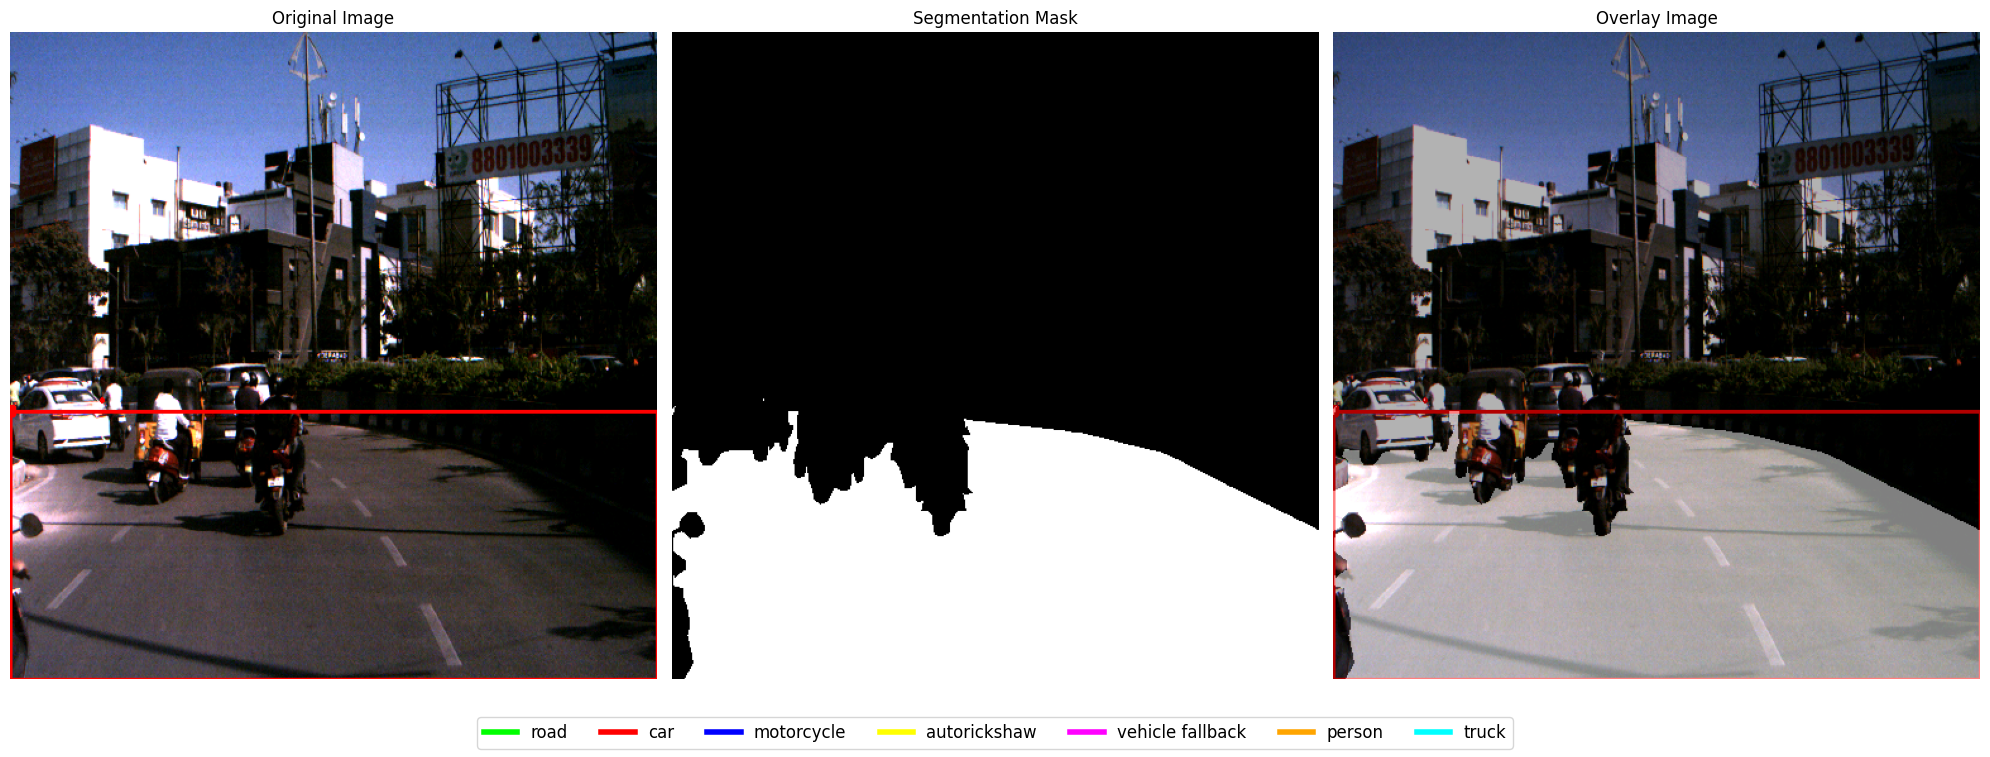

✅ Done! Original, Segmentation, and Overlay images displayed together.


In [71]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Load image and mask (mask is now a PNG file)
image_path = r"/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_0.png"
mask_path = r"/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_0.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Read mask as grayscale (single channel)
height, width = image.shape[:2]

# Target labels (including 'truck' now) and the corresponding mask values
target_labels = ['car', 'motorcycle', 'autorickshaw', 'vehicle fallback', 'road', 'person', 'truck']
label_values = [1, 2, 3, 4, 5, 6, 7]  # Assuming these are the unique values in the mask for each class

# Colors for visualization
simple_colors = {
    'road': [0, 255, 0],              # Green
    'car': [255, 0, 0],               # Red
    'motorcycle': [0, 0, 255],         # Blue
    'autorickshaw': [255, 255, 0],     # Yellow
    'vehicle fallback': [255, 0, 255], # Pink
    'person': [255, 165, 0],           # Orange
    'truck': [0, 255, 255]             # Cyan (added truck color)
}

# Store objects (optional)
selected_objects = []

# Blank mask (single channel, no need for 3 channels for a segmentation mask)
selected_mask = np.zeros((height, width), dtype=np.uint8)

# Loop through each target label and find the corresponding mask values
for label, value in zip(target_labels, label_values):
    # Create a mask for the current label
    label_mask = (mask == value).astype(np.uint8)  # Create binary mask for the current class

    # Find contours of the labeled areas (optional for visualization of polygons)
    contours, _ = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if len(contour) > 1:  # Only consider valid contours with more than 1 point
            # Draw the contour on the selected mask
            cv2.drawContours(selected_mask, [contour], -1, 255, thickness=cv2.FILLED)

            # Get bounding box coordinates for the object
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), simple_colors[label], 2)

            # Store object info for later (optional)
            selected_objects.append({
                "Label": label,
                "Bounding Box": f"({x}, {y}), ({x + w}, {y + h})"
            })

# Save to CSV (optional)
df_selected = pd.DataFrame(selected_objects)
df_selected.to_csv('vehicle_road_objects.csv', index=False)

# Create overlay: blend the original image with the mask
overlay = cv2.addWeighted(image, 0.7, cv2.cvtColor(selected_mask, cv2.COLOR_GRAY2RGB), 0.5, 0)

# Plot all together
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(selected_mask, cmap='gray')
axs[1].set_title('Segmentation Mask')
axs[1].axis('off')

axs[2].imshow(overlay)
axs[2].set_title('Overlay Image')
axs[2].axis('off')

# Legend (only once for clarity)
legend_elements = [plt.Line2D([0], [0], color=(c[0]/255, c[1]/255, c[2]/255), lw=4, label=label)
                   for label, c in simple_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=7, fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Done! Original, Segmentation, and Overlay images displayed together.")


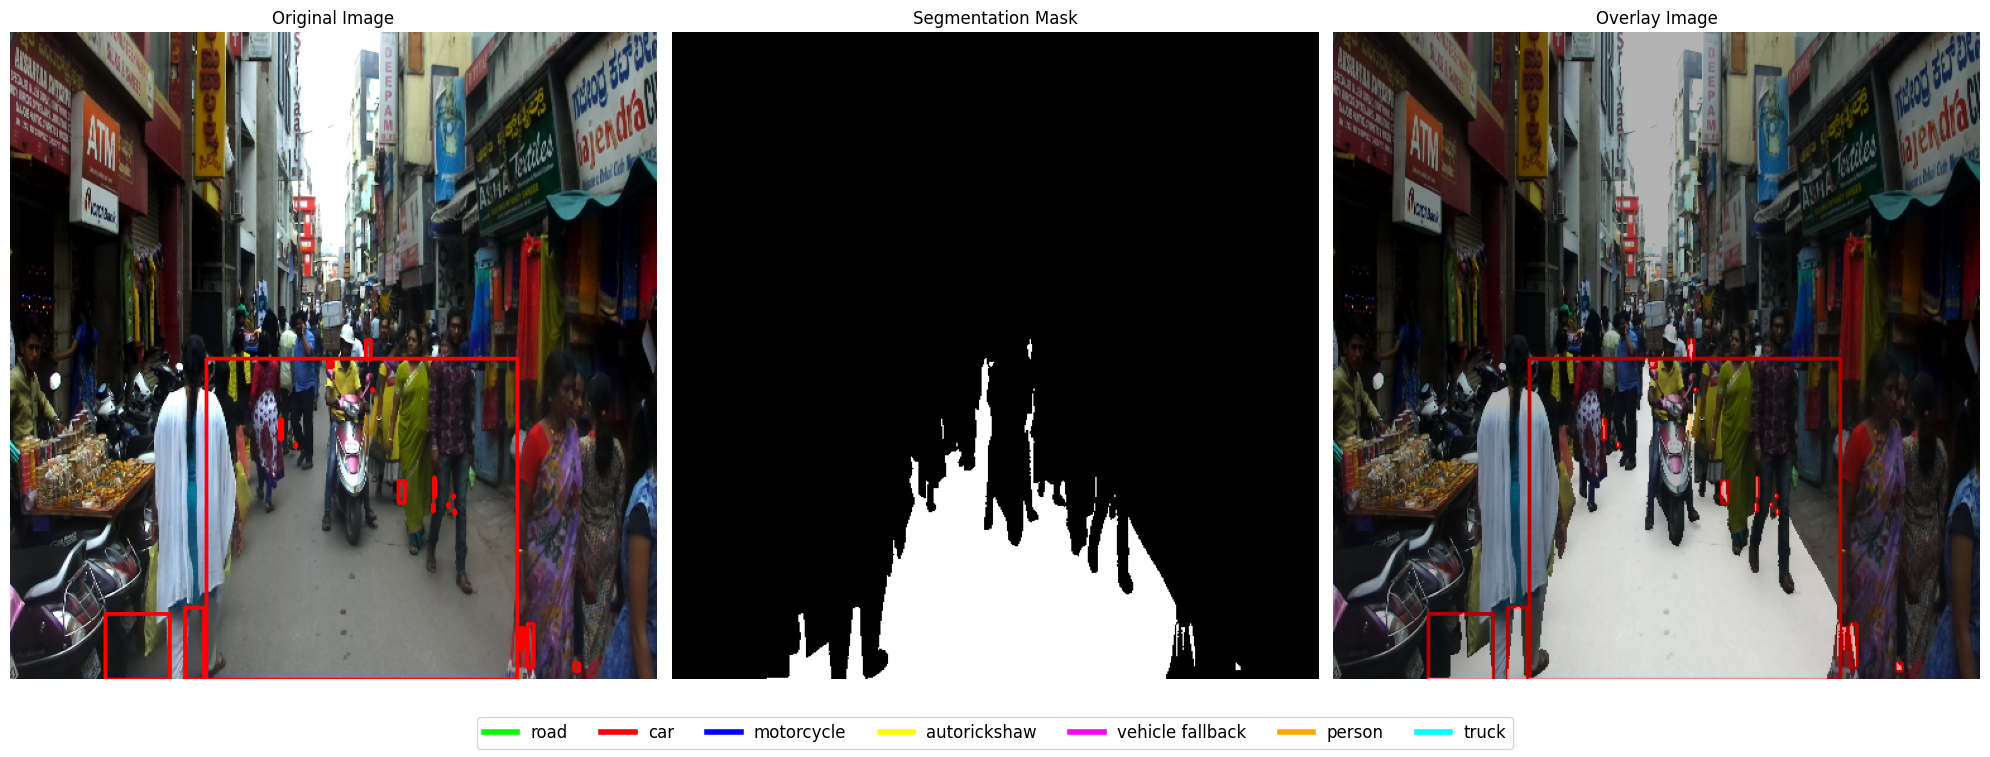

✅ Done! Original, Segmentation, and Overlay images displayed together.


In [72]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Load image and mask (mask is now a PNG file)
image_path = r"/content/new-idd-dataset/IDD_RESIZED/image_archive/Image_100.png"
mask_path = r"/content/new-idd-dataset/IDD_RESIZED/mask_archive/Mask_100.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Read mask as grayscale (single channel)
height, width = image.shape[:2]

# Target labels (including 'truck' now) and the corresponding mask values
target_labels = ['car', 'motorcycle', 'autorickshaw', 'vehicle fallback', 'road', 'person', 'truck']
label_values = [1, 2, 3, 4, 5, 6, 7]  # Assuming these are the unique values in the mask for each class

# Colors for visualization
simple_colors = {
    'road': [0, 255, 0],              # Green
    'car': [255, 0, 0],               # Red
    'motorcycle': [0, 0, 255],         # Blue
    'autorickshaw': [255, 255, 0],     # Yellow
    'vehicle fallback': [255, 0, 255], # Pink
    'person': [255, 165, 0],           # Orange
    'truck': [0, 255, 255]             # Cyan (added truck color)
}

# Store objects (optional)
selected_objects = []

# Blank mask (single channel, no need for 3 channels for a segmentation mask)
selected_mask = np.zeros((height, width), dtype=np.uint8)

# Loop through each target label and find the corresponding mask values
for label, value in zip(target_labels, label_values):
    # Create a mask for the current label
    label_mask = (mask == value).astype(np.uint8)  # Create binary mask for the current class

    # Find contours of the labeled areas (optional for visualization of polygons)
    contours, _ = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if len(contour) > 1:  # Only consider valid contours with more than 1 point
            # Draw the contour on the selected mask
            cv2.drawContours(selected_mask, [contour], -1, 255, thickness=cv2.FILLED)

            # Get bounding box coordinates for the object
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), simple_colors[label], 2)

            # Store object info for later (optional)
            selected_objects.append({
                "Label": label,
                "Bounding Box": f"({x}, {y}), ({x + w}, {y + h})"
            })

# Save to CSV (optional)
df_selected = pd.DataFrame(selected_objects)
df_selected.to_csv('vehicle_road_objects.csv', index=False)

# Create overlay: blend the original image with the mask
overlay = cv2.addWeighted(image, 0.7, cv2.cvtColor(selected_mask, cv2.COLOR_GRAY2RGB), 0.5, 0)

# Plot all together
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(selected_mask, cmap='gray')
axs[1].set_title('Segmentation Mask')
axs[1].axis('off')

axs[2].imshow(overlay)
axs[2].set_title('Overlay Image')
axs[2].axis('off')

# Legend (only once for clarity)
legend_elements = [plt.Line2D([0], [0], color=(c[0]/255, c[1]/255, c[2]/255), lw=4, label=label)
                   for label, c in simple_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=7, fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Done! Original, Segmentation, and Overlay images displayed together.")
